<a href="https://www.kaggle.com/cameron858/spaceship-titanic-various-models?scriptVersionId=89128912" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Load training data into pandas dataframe

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
submission = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")

print(f'{train.head()}\n{train.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   


In [2]:
# examine Nans

print(f'Training NaNs:\n{train.isnull().sum()}\n\nTesting NaNs:\n{test.isnull().sum()}')

Training NaNs:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Testing NaNs:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


There are numerous NaNs in the dataset.They will just be ignored for now

In [3]:
#train, test = train.dropna(), test.dropna()
#print(f'Training NaNs:\n{train.isnull().sum()}\n\nTesting NaNs:\n{test.isnull().sum()}')

# Feature creation #

Numerous features can be split into more features. The PassengerId has the format of 'XXXX_XX'. We can split the first 4 digits, and last 2 into seperate features. The cabin format is of "deck / number / side (port P or startboard S). We can seperate these into seperate columns. It is a valid assumption that families travel together, and stay in the same rooms. First and Last name features can be created from the original names feature. The 3 original features have been dropped afterwards.

In [4]:
# splitting PassengerId feature
train[['PassengerId_0', 'PassengerId_1']] = train['PassengerId'].str.split('_', 1, expand=True)
test[['PassengerId_0', 'PassengerId_1']] = test['PassengerId'].str.split('_', 1, expand=True)

# splitting Cabin feature
train[['Deck', 'Number', 'Side']] = train['Cabin'].str.split('/', 2, expand=True)
test[['Deck', 'Number', 'Side']] = test['Cabin'].str.split('/', 2, expand=True)

# splitting Name feature
train[['First name', 'Family name']] = train['Name'].str.split(' ', 1, expand=True)
test[['First name', 'Family name']] = test['Name'].str.split(' ', 1, expand=True)

# drop old features
train.drop(['PassengerId', 'Cabin', 'Name'], axis=1, inplace=True)
test.drop(['PassengerId', 'Cabin', 'Name'], axis=1, inplace=True)

# snacks 
train['Food/drink'] = train['RoomService'] + train['FoodCourt']
test['Food/drink'] = test['RoomService'] + test['FoodCourt']

# Entertainment
train['Entertainment'] = train['Spa'] + train['VRDeck']
test['Entertainment'] = test['Spa'] + test['VRDeck']

# Total spent
train['TotalSpent'] = train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck']
test['TotalSpent'] = test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa'] + test['VRDeck']

print(f'Training:\n{train.head()}\nTesting:\n{test.head()}')

Training:
  HomePlanet CryoSleep  Destination   Age    VIP  RoomService  FoodCourt  \
0     Europa     False  TRAPPIST-1e  39.0  False          0.0        0.0   
1      Earth     False  TRAPPIST-1e  24.0  False        109.0        9.0   
2     Europa     False  TRAPPIST-1e  58.0   True         43.0     3576.0   
3     Europa     False  TRAPPIST-1e  33.0  False          0.0     1283.0   
4      Earth     False  TRAPPIST-1e  16.0  False        303.0       70.0   

   ShoppingMall     Spa  VRDeck  ...  PassengerId_0 PassengerId_1 Deck Number  \
0           0.0     0.0     0.0  ...           0001            01    B      0   
1          25.0   549.0    44.0  ...           0002            01    F      0   
2           0.0  6715.0    49.0  ...           0003            01    A      0   
3         371.0  3329.0   193.0  ...           0003            02    A      0   
4         151.0   565.0     2.0  ...           0004            01    F      1   

  Side First name  Family name Food/drink  Ent

Scale continuous features

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# scale continuous features
continuous_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Food/drink', 'Entertainment', 'TotalSpent']
min_max_scaler = MinMaxScaler()
train[continuous_cols] = min_max_scaler.fit_transform(train[continuous_cols])
test[continuous_cols] = min_max_scaler.fit_transform(test[continuous_cols])

# impute columns with missing values
impute_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
               'Food/drink', 'Entertainment', 'TotalSpent']
imputer = SimpleImputer(strategy="most_frequent")
train[impute_cols] = imputer.fit_transform(train[impute_cols])
test[impute_cols] = imputer.fit_transform(test[impute_cols])

In [6]:
from sklearn.preprocessing import LabelEncoder

def encode_df_cols(df, columns):
    for col in columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype('str'))   
    return df

cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Number', 'Side', 'First name', 'Family name']
train = encode_df_cols(train, cat_cols)
test = encode_df_cols(test, cat_cols)

print(f'Training:\n{train.head()}\nTesting:\n{test.head()}')

Training:
   HomePlanet  CryoSleep  Destination       Age  VIP RoomService FoodCourt  \
0           1          0            2  0.493671    0         0.0       0.0   
1           0          0            2  0.303797    0    0.007608  0.000302   
2           1          0            2  0.734177    1    0.003001  0.119948   
3           1          0            2  0.417722    0         0.0  0.043035   
4           0          0            2  0.202532    0    0.021149  0.002348   

  ShoppingMall       Spa    VRDeck  ...  PassengerId_0 PassengerId_1 Deck  \
0          0.0       0.0       0.0  ...           0001            01    1   
1     0.001064    0.0245  0.001823  ...           0002            01    5   
2          0.0   0.29967   0.00203  ...           0003            01    0   
3     0.015793  0.148563  0.007997  ...           0003            02    0   
4     0.006428  0.025214  0.000083  ...           0004            01    5   

   Number  Side  First name  Family name  Food/drink Enter

In [7]:
train.isnull().sum()

HomePlanet       0
CryoSleep        0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Transported      0
PassengerId_0    0
PassengerId_1    0
Deck             0
Number           0
Side             0
First name       0
Family name      0
Food/drink       0
Entertainment    0
TotalSpent       0
dtype: int64

# Feature Selections #

This sections aims to evaluate each feature in relation to the target ('Transported'). This should assist our models decisions. The numerical and categorical features will be evaluated seperately.

## Numerical features ##

In [8]:
# list numerical features from previous section
continuous_cols

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Food/drink',
 'Entertainment',
 'TotalSpent']

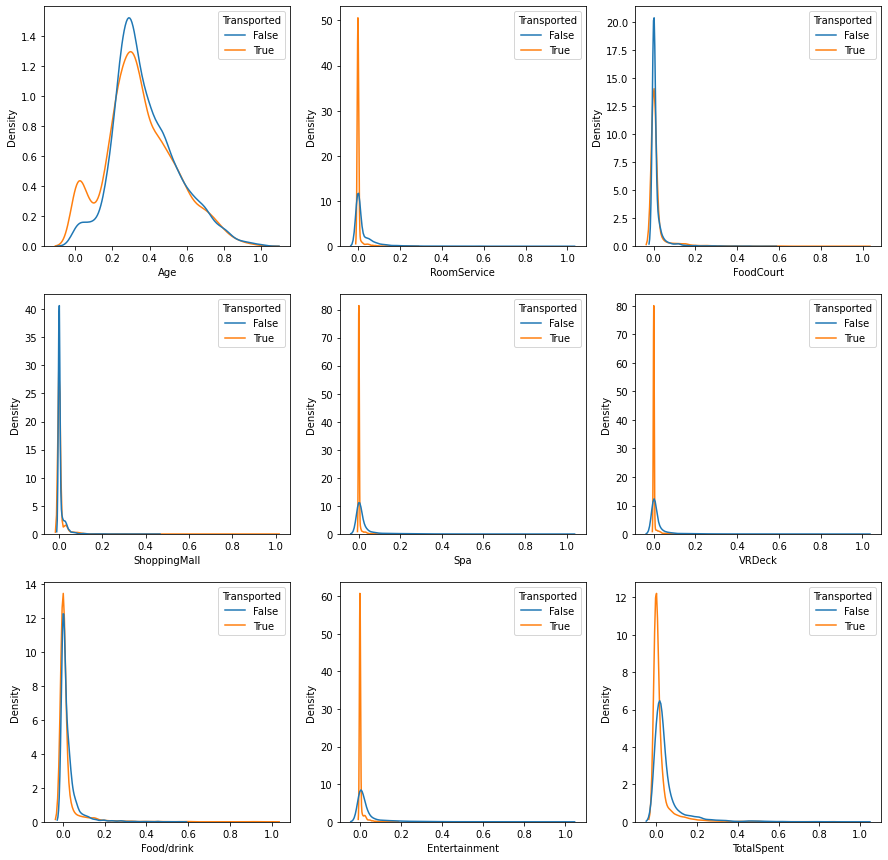

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
idx = 0

for row in range(0,3):
    for col in range(0,3):
        sns.kdeplot(data=train, x=continuous_cols[idx], hue="Transported", ax=ax[row][col])
        idx+=1

<AxesSubplot:>

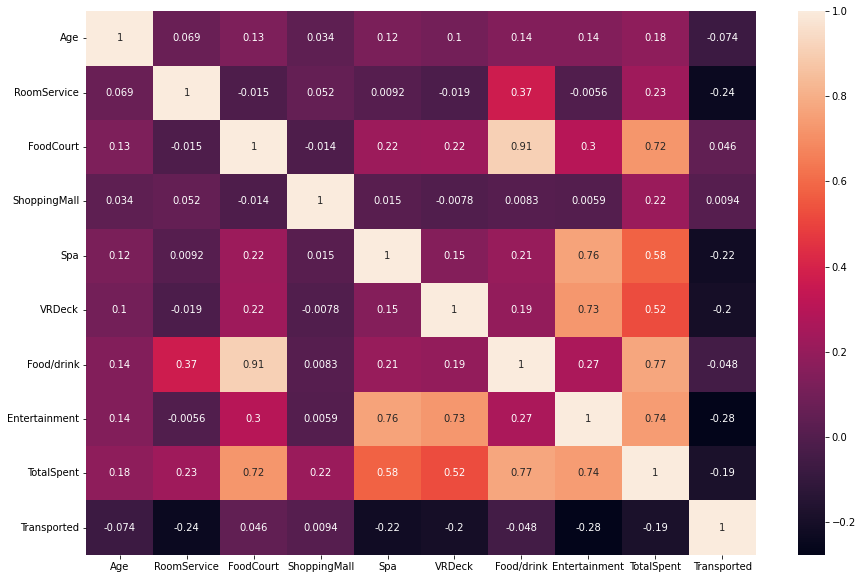

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))

# astype(float) to avoid empty dataframe error
numerical_corrs = train[continuous_cols + ['Transported']].astype(float).corr()
sns.heatmap(numerical_corrs, annot=True, ax=ax)

In [11]:
# sort numerical features from largest to smallest abs correlation
print(numerical_corrs['Transported'].abs().sort_values(ascending=False))

Transported      1.000000
Entertainment    0.277275
RoomService      0.241124
Spa              0.218545
VRDeck           0.204874
TotalSpent       0.185550
Age              0.074153
Food/drink       0.048293
FoodCourt        0.045583
ShoppingMall     0.009391
Name: Transported, dtype: float64


# Categorical features #

<AxesSubplot:>

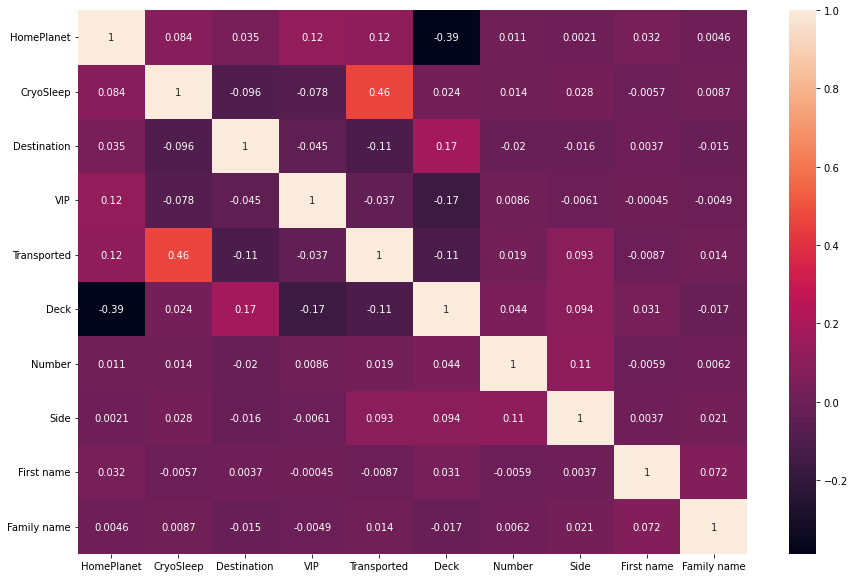

In [12]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(train.corr(), annot=True)

Split into train and test data

In [13]:
Y_train = train['Transported']
X_train = train.loc[:, train.columns != 'Transported']

# Models #

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [14]:
from sklearn.neural_network import MLPClassifier

neural_net = MLPClassifier(hidden_layer_sizes=(200, 100, 1), early_stopping=True, validation_fraction=0.2, verbose=True)
neural_net.fit(X_train, Y_train)

Iteration 1, loss = 0.74754556
Validation score: 0.503738
Iteration 2, loss = 0.74220412
Validation score: 0.503738
Iteration 3, loss = 0.73731196
Validation score: 0.503738
Iteration 4, loss = 0.73280041
Validation score: 0.503738
Iteration 5, loss = 0.72860356
Validation score: 0.503738
Iteration 6, loss = 0.72476068
Validation score: 0.503738
Iteration 7, loss = 0.72124694
Validation score: 0.503738
Iteration 8, loss = 0.71800153
Validation score: 0.503738
Iteration 9, loss = 0.71507831
Validation score: 0.503738
Iteration 10, loss = 0.71243977
Validation score: 0.503738
Iteration 11, loss = 0.71008667
Validation score: 0.503738
Iteration 12, loss = 0.70786509
Validation score: 0.503738
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(early_stopping=True, hidden_layer_sizes=(200, 100, 1),
              validation_fraction=0.2, verbose=True)

Neural network seems to do little better than just randomly guessing

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_params = {'n_neighbors': [3, 5, 7]}
knn = GridSearchCV(KNeighborsClassifier(), knn_params, n_jobs=4, refit=True, verbose=1, return_train_score=True)
knn.fit(X_train, Y_train)
print(knn.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.47498688120826554


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    5.8s finished


In [16]:
from sklearn.svm import SVC

#svc_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
#svc = GridSearchCV(SVC(), svc_params, n_jobs=4, verbose=2)
svc = SVC(kernel='rbf').fit(X_train, Y_train)

Initial run scored 54%

In [17]:
from sklearn.gaussian_process import GaussianProcessClassifier

gpc = GaussianProcessClassifier().fit(X_train, Y_train)

In [18]:
def create_submission(model):
    submission['Transported'] = model.predict(test)
    submission.to_csv("/kaggle/working/submission.csv", index=False)
    
create_submission(gpc)